In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [3]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2017-05-28,182.36,156.51,156.51,765913.66,1.272252e+08,172.86,direct,
2017-05-29,197.74,165.36,172.86,649778.58,1.173645e+08,194.17,direct,
2017-05-30,232.08,185.83,194.17,1246427.54,2.595135e+08,228.58,direct,
2017-05-31,233.92,214.05,228.58,1010028.21,2.257407e+08,228.64,direct,
2017-06-01,235.52,208.00,228.64,855293.22,1.887444e+08,220.70,direct,
...,...,...,...,...,...,...,...,...
2022-11-14,1288.74,1170.90,1219.85,697240.74,8.558588e+08,1241.39,direct,
2022-11-15,1288.55,1232.81,1241.39,575085.30,7.236280e+08,1252.00,direct,
2022-11-16,1266.73,1185.82,1252.00,607212.63,7.422893e+08,1215.24,direct,


In [4]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-05-28,182.36,156.51,156.51,765913.66,1.272252e+08,172.86
2017-05-29,197.74,165.36,172.86,649778.58,1.173645e+08,194.17
2017-05-30,232.08,185.83,194.17,1246427.54,2.595135e+08,228.58
2017-05-31,233.92,214.05,228.58,1010028.21,2.257407e+08,228.64
2017-06-01,235.52,208.00,228.64,855293.22,1.887444e+08,220.70
...,...,...,...,...,...,...
2022-11-14,1288.74,1170.90,1219.85,697240.74,8.558588e+08,1241.39
2022-11-15,1288.55,1232.81,1241.39,575085.30,7.236280e+08,1252.00
2022-11-16,1266.73,1185.82,1252.00,607212.63,7.422893e+08,1215.24


In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [6]:

def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(df,test_size=0.4)

In [8]:
np.array(train)
np.array(test)

array([[3.77540000e+02, 3.50440000e+02, 3.51150000e+02, 6.74808420e+05,
        2.48139179e+08, 3.68090000e+02],
       [3.75310000e+02, 3.56150000e+02, 3.68090000e+02, 4.41319300e+05,
        1.61816529e+08, 3.73990000e+02],
       [3.88140000e+02, 3.69960000e+02, 3.74030000e+02, 6.98082560e+05,
        2.70883063e+08, 3.88040000e+02],
       ...,
       [1.26673000e+03, 1.18582000e+03, 1.25200000e+03, 6.07212630e+05,
        7.42289325e+08, 1.21524000e+03],
       [1.22703000e+03, 1.18192000e+03, 1.21524000e+03, 4.72447650e+05,
        5.68626213e+08, 1.19945000e+03],
       [1.23160000e+03, 1.19820000e+03, 1.19945000e+03, 1.67944020e+05,
        2.04079469e+08, 1.21933000e+03]])

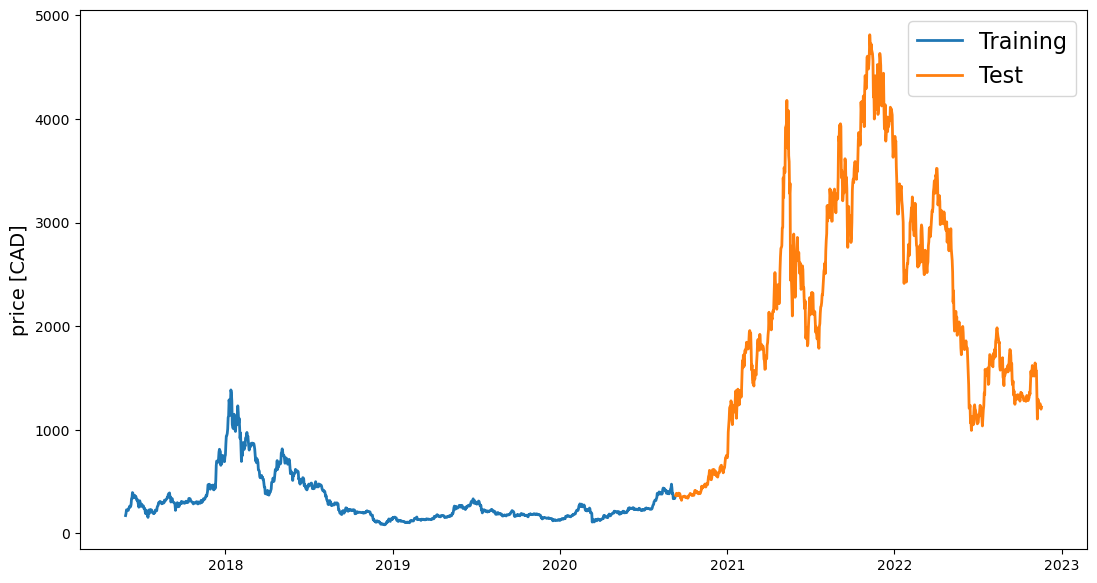

In [9]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [10]:
print(train)
print(test)

              high     low    open  volumefrom      volumeto   close
time                                                                
2017-05-28  182.36  156.51  156.51   765913.66  1.272252e+08  172.86
2017-05-29  197.74  165.36  172.86   649778.58  1.173645e+08  194.17
2017-05-30  232.08  185.83  194.17  1246427.54  2.595135e+08  228.58
2017-05-31  233.92  214.05  228.58  1010028.21  2.257407e+08  228.64
2017-06-01  235.52  208.00  228.64   855293.22  1.887444e+08  220.70
...            ...     ...     ...         ...           ...     ...
2020-09-05  394.66  310.93  385.91  1499688.45  5.220170e+08  335.24
2020-09-06  360.31  316.82  335.24   958760.77  3.272806e+08  352.69
2020-09-07  358.54  323.67  352.69   693531.32  2.382644e+08  353.70
2020-09-08  356.57  325.75  353.70   655015.89  2.225580e+08  337.45
2020-09-09  359.20  331.01  337.45   547236.41  1.900443e+08  351.15

[1201 rows x 6 columns]
               high      low     open  volumefrom      volumeto    close
time 

In [11]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [12]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [13]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [14]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [15]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 100
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [16]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [17]:
#Early stopping using callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=4)

In [18]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks=[es])

Epoch 1/40
38/38 [==============================] - 3s 24ms/step - loss: 0.0098 - val_loss: 0.0062
Epoch 2/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 3/40
38/38 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 4/40
38/38 [==============================] - 0s 9ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 5/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 6/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 7/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 9/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 11/40
38/38 

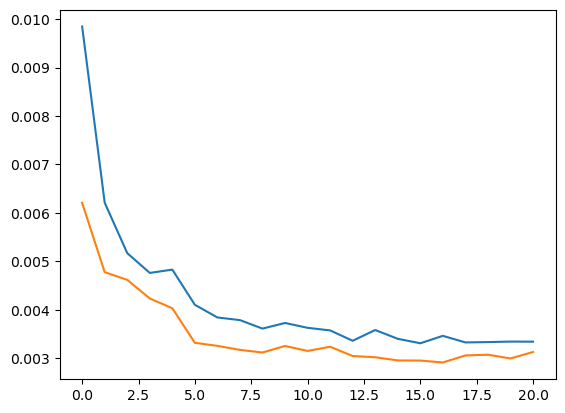

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [20]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

25/25 [==============================] - 0s 1ms/step


0.04113294828310127

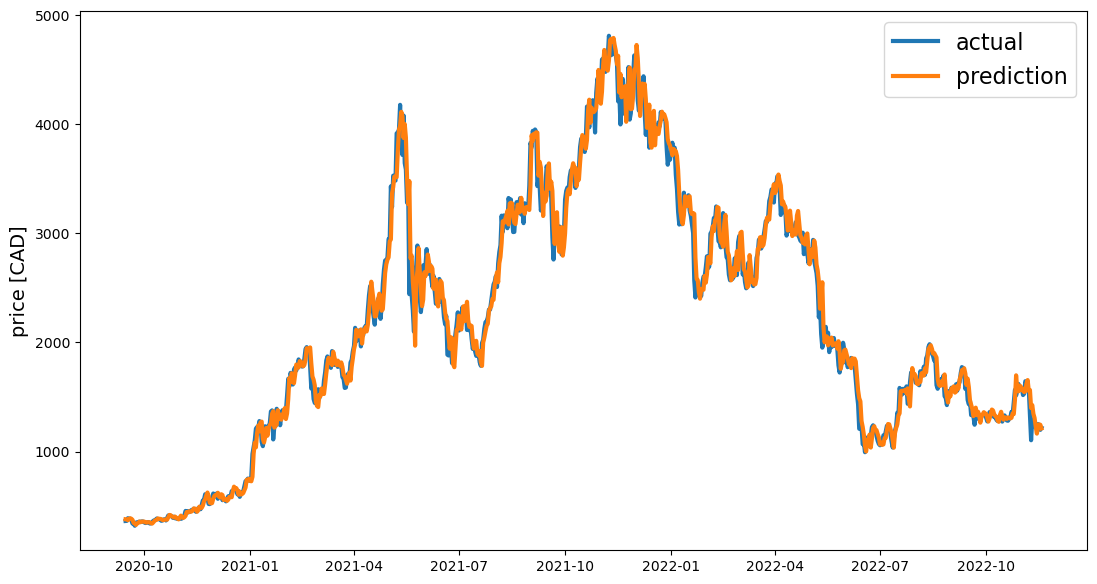

In [21]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [22]:
model.save('ETHmodel.hdf5')